# Fourth Classifier

This time, classify the data *only* using flag and ethnicity data.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(font='monospace')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 150)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(flag_cols | ethnicity_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 37)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.5097320261437908


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.000000,0.894737,1.000000,0.000000,0.526144
1,0.000000,0.842105,0.941176,0.000000,0.555556
2,0.000000,0.894737,1.000000,0.000000,0.457516
3,0.000000,0.859649,0.960784,0.000000,0.207516
4,0.000000,0.842105,0.941176,0.000000,0.333333
5,0.000000,0.807018,0.901961,0.000000,0.418301
6,0.000000,0.894737,1.000000,0.000000,0.557190
7,0.285714,0.912281,1.000000,0.166667,0.661765
8,0.000000,0.857143,0.960000,0.000000,0.730000
9,0.000000,0.872727,0.960000,0.000000,0.650000


flag_Juvenile             0.160787
flag_Foreign Providers    0.105630
flag_Traveling            0.102003
ethnicity_Latina          0.063406
ethnicity_White           0.062981
ethnicity_Ebony           0.061688
ethnicity_Rican           0.042452
ethnicity_Indian          0.042388
ethnicity_Asian           0.037935
flag_Multiple Girls       0.034119
ethnicity_French          0.030973
ethnicity_Dominican       0.029481
ethnicity_Brazilian       0.021568
ethnicity_Thai            0.016649
ethnicity_Cuban           0.016465
ethnicity_Caucasian       0.015385
ethnicity_Spanish         0.014839
flag_URL Embedding        0.014263
ethnicity_Latin           0.013584
flag_Massage Parlor       0.012106
dtype: float64


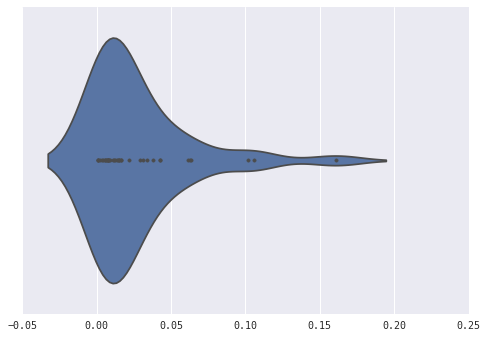

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

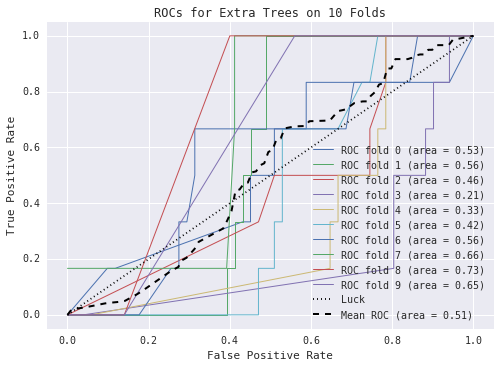

In [9]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [10]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [11]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.545313725490196


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.000000,0.894737,1.000000,0.000000,0.555556
1,0.000000,0.859649,0.960784,0.000000,0.553922
2,0.000000,0.894737,1.000000,0.000000,0.449346
3,0.000000,0.877193,0.980392,0.000000,0.328431
4,0.000000,0.842105,0.941176,0.000000,0.424837
5,0.000000,0.789474,0.882353,0.000000,0.462418
6,0.000000,0.894737,1.000000,0.000000,0.635621
7,0.285714,0.912281,1.000000,0.166667,0.683007
8,0.000000,0.839286,0.940000,0.000000,0.730000
9,0.000000,0.872727,0.960000,0.000000,0.630000


flag_Juvenile             0.210274
flag_Foreign Providers    0.128387
flag_Traveling            0.115259
ethnicity_Latina          0.069239
ethnicity_White           0.059795
ethnicity_Ebony           0.059613
ethnicity_Rican           0.043826
flag_Multiple Girls       0.042878
ethnicity_Indian          0.039624
ethnicity_Asian           0.037262
ethnicity_French          0.029288
ethnicity_Dominican       0.020025
ethnicity_Latin           0.016719
ethnicity_Brazilian       0.016194
ethnicity_Spanish         0.012948
ethnicity_Thai            0.012016
flag_URL Embedding        0.011194
ethnicity_Cuban           0.010717
flag_Hotel                0.007764
flag_Massage Parlor       0.007626
dtype: float64


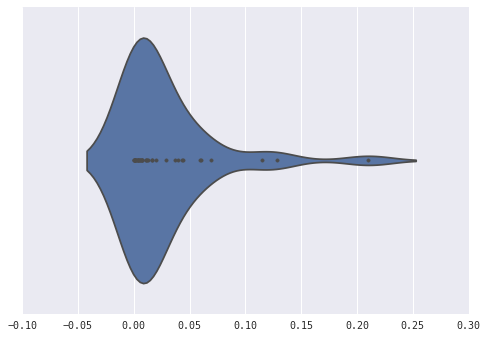

In [12]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

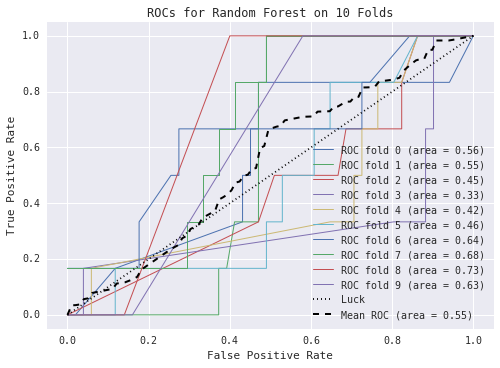

In [13]:
draw_rocs(this_metrics, 'Random Forest')